# SisyphusRemover Proof of Concept (PoC) Development

1. [Goals](#section_1)

2. [Assumptions](#section_2)

3. [Analysis Setup](#section_3)

    [3.1 Libraries](#section_3_1)
    
    [3.2 Custom Options](#section_3_2)

4. [Data](#section_4)

    [4.1 Data Overview](#section_4_1)

    [4.2 Data Ignest & Pre-Processing](#section_4_2)

    [4.3 Repair Job Message Embeddings](#section_4_3)

5. [Reoccurring Job Identification](#section_5)

6. [Conclusion/Next Steps](#section_6)



## 1. Goals  <a class="anchor" id="section_1"></a>

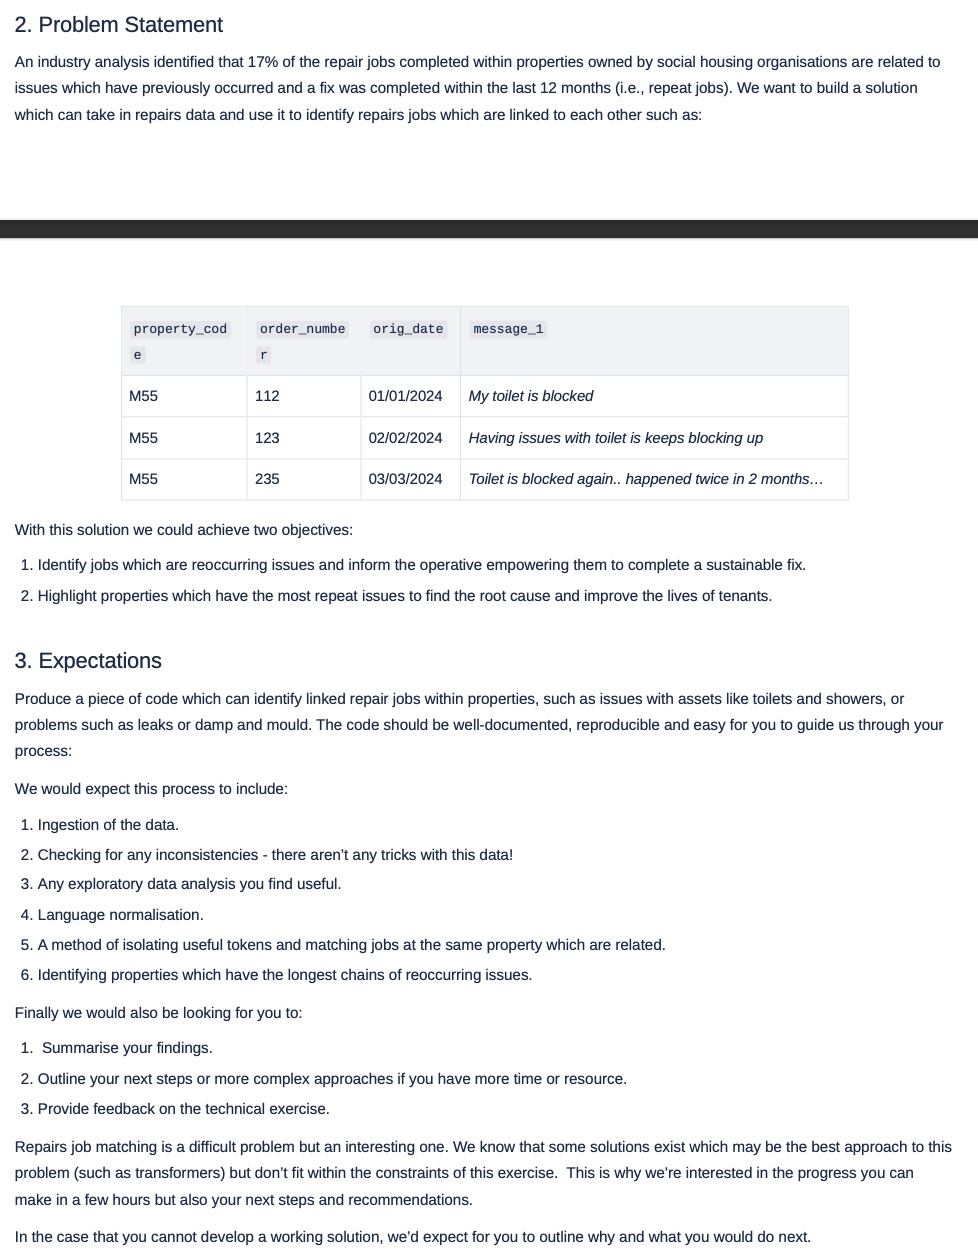

## 2. Assumptions  <a class="anchor" id="section_2"></a>

a. Given expectations outlined above we are not allowed to use anything that would clearly exceed 3-4 hours time window including training time i.e. no Deep Learning (DL), any other Machine Learning (ML) needs to be trainable on a local machine within allocated time.

b. It is stated that there are no tricks with the data so we will assume this is a mature, clean and well understood sample of an existing table i.e. we will apply simple quality checks mosty aimed at checking correctness of our own code and more importantly we will treat entirety of free text data within `message_1` variable as potentially meaningiful.

c. Points 3-5 within "Expectations" subsection outlined above, heavily suggest we are expect to tokenize `message_1` and apply standard Natural Language Processing (NLP) pre-processing & Exploratory Data Analysis (EDA) like stop-word removal, Bag of Words, TF-IDF etc. However based on the initial look of the data (short/"information poor" job messages), phrasing of the goals (you already have solution like that; small data size makes it feasible to use expensive top of the line embeddings models) and time scales we will use embedding based approach and use corressponding substitutes. Please note that for this reason some of the standard text pre-processing might be "hidden" since when we use good embedding model APIs they will conduct their own pre-processing aligned with to their particular model. 

d. My initial hypothesis is that data provided is not quite enough to build a fully nuanced solution e.g. mentions of "toilet" can conflate completely different plumbing issues etc. So in real-life we would probably start from trying to enhance this with some other data, if that would not be possible then we would probably want to look in enriching the data collection proces. For the purposes of this exercise we will simply assume that similar jobs are the same as reoccuring jobs - please note this is is a very strong assumption.

e. Since the outcome of this clearly fits as a feature of RepairSense, I thought that SisyphusRemover would be a fitting name.

## 3. Analysis Setup  <a class="anchor" id="section_3"></a>

### 3.1 Libraries <a class="anchor" id="section_3_1"></a>

In [30]:
# External packages

# Enchanced Python shell class for contro lling Jupyter outputs
from IPython.core.interactiveshell import InteractiveShell
# Mathematical & tensor operations
import numpy as np
# Data manipulation
import pandas as pd
# OpenAI API
from openai import OpenAI
# System interfaces
import os
# System parameters/functions
import sys
# Loading custom environment paramaters
from dotenv import load_dotenv
# Regular expressions
import re
# Clustering model & associated metric
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Static plots
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Set environment variables from local config file (not version controlled)
load_dotenv()

# Add local "PATH_TO_SOURCE" environment variable to sys.path so we can import our bespoke modules
module_path = os.path.abspath(os.path.join(os.getenv("PATH_TO_SOURCE")))
if module_path not in sys.path:
    sys.path.append(module_path)

# Internal packages
from eda import assess_data_frame_quality

True

### 3.3 Custom Options <a class="anchor" id="section_3_3"></a>

In [3]:
# Make Jupyter print all outputs
InteractiveShell.ast_node_interactivity = "all"

# Increase maximum limits on pandas methods to print everything
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_info_rows', 500)

True

## 4. Data  <a class="anchor" id="section_4"></a>



### 4.1 Data Overview <a class="anchor" id="section_4_1"></a>

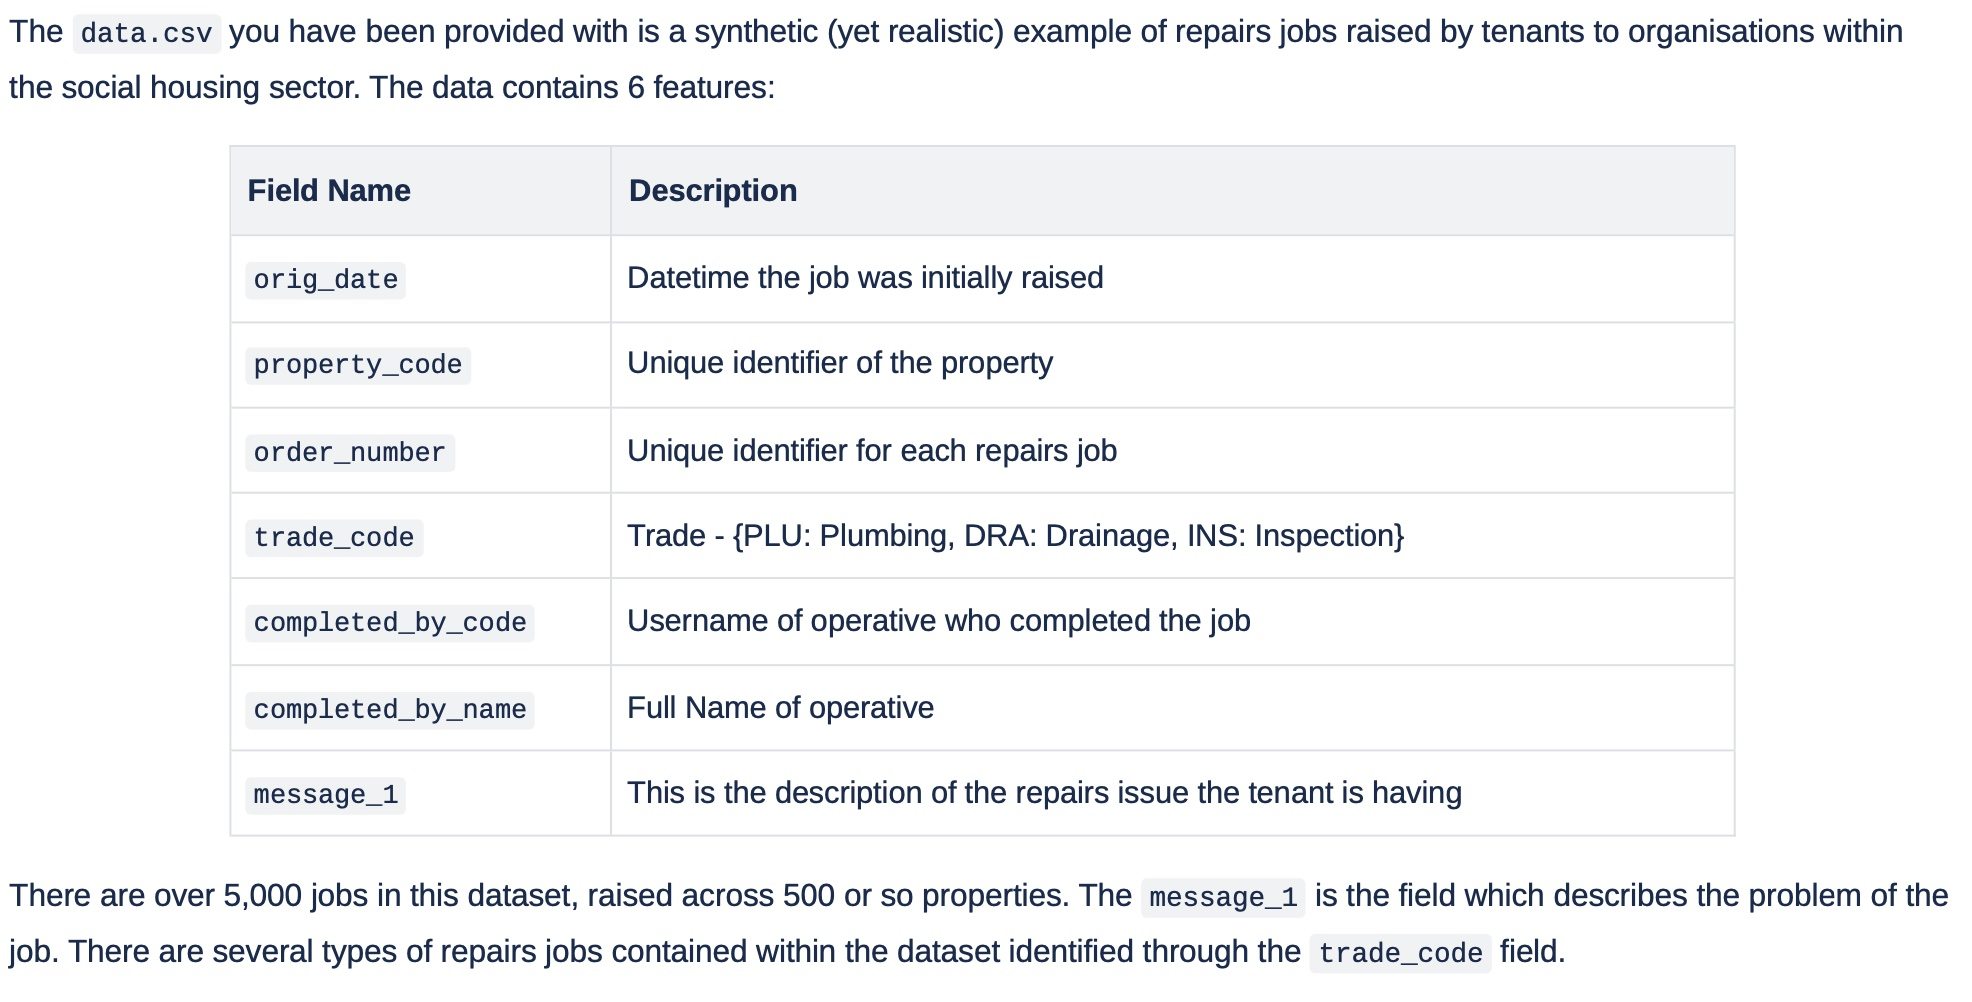

### 4.2 Data Ignest & Pre-Processing <a class="anchor" id="section_4_2"></a>

Let's look at the raw CSV, which is actually called "SeniorDSTechnicalTest_data.csv", to confirm there are no special adjustment we need to make to ignest it.

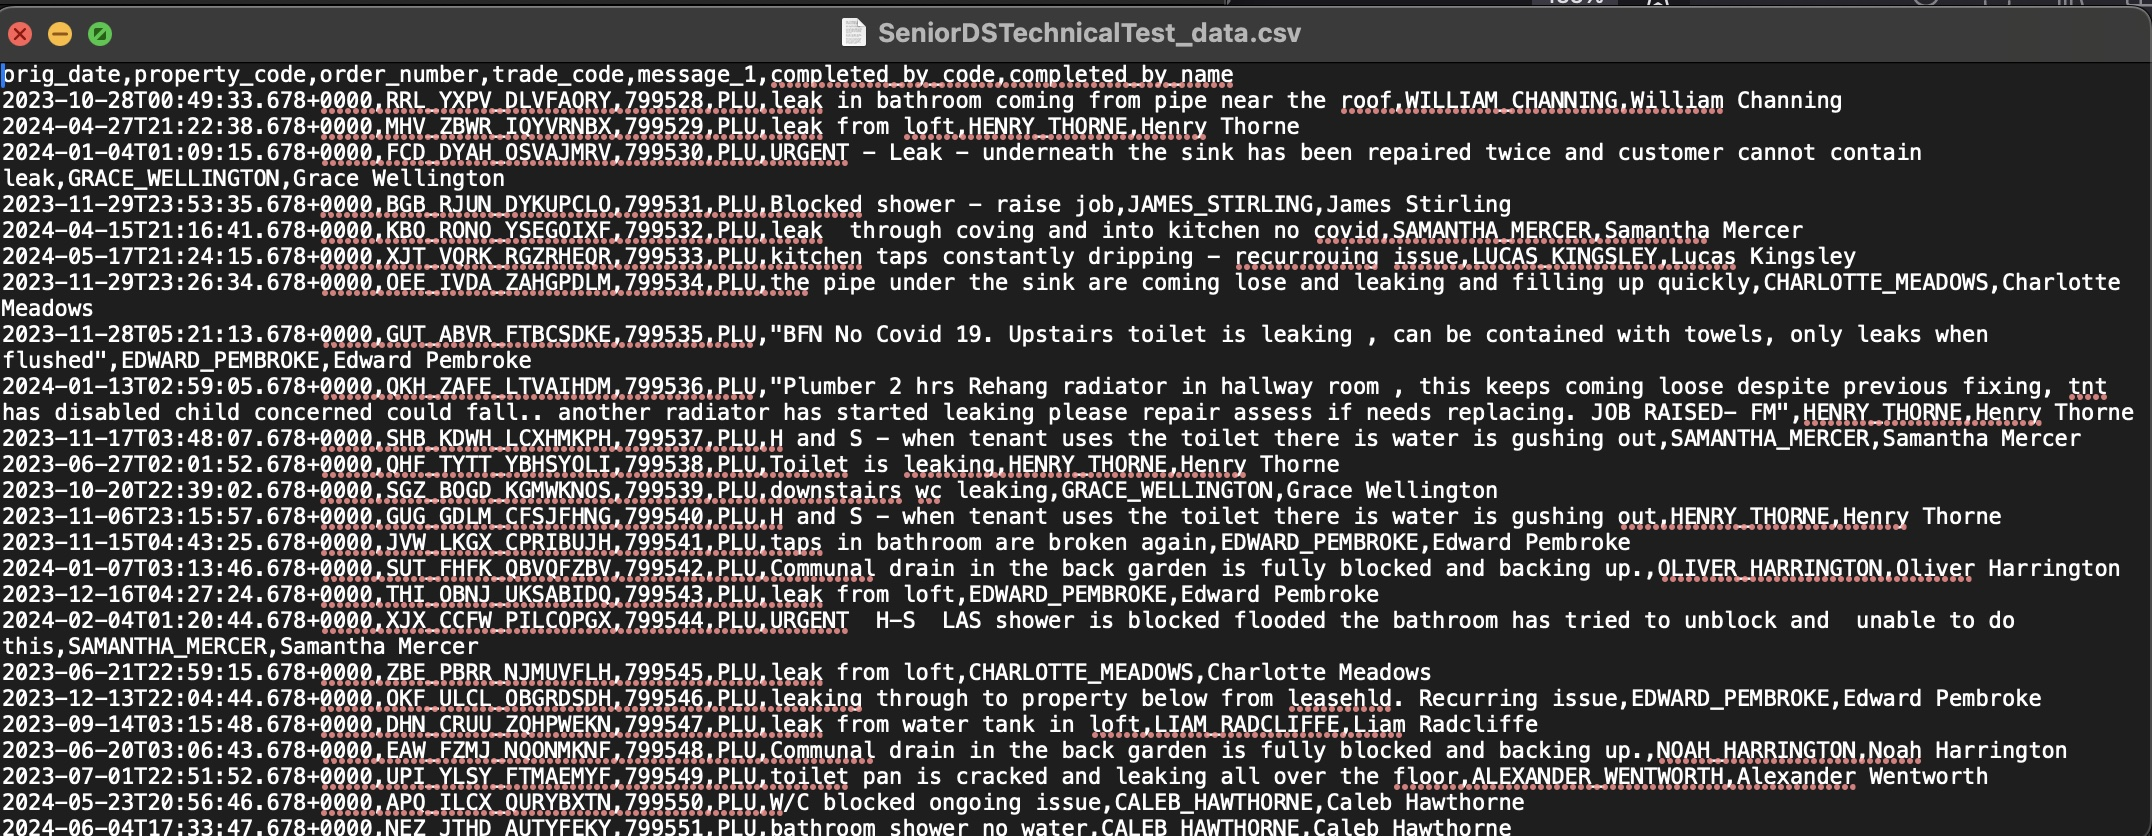

There are no obvious problems so let's ignest the CSV and have a look at its data quality.

In [14]:
# Define path to "SeniorDSTechnicalTest_data.csv" using local "PATH_TO_DATA" environment variable
data_path = ("%s/SeniorDSTechnicalTest_data.csv" % os.getenv("PATH_TO_DATA")).replace("\n", "")

# Read-in the dataset
data = pd.read_csv(data_path)

# Sense check above by looking at top/bottom rows, data types, prevalence of nulls and summary stats
assess_data_frame_quality(
    raw_data_frame = data,
    dataset_name = "SeniorDSTechnicalTest_data.csv")

'Data quality assessment for `SeniorDSTechnicalTest_data.csv`:'

'Top 20 observations:'

,orig_date,property_code,order_number,trade_code,message_1,completed_by_code,completed_by_name
0,2023-10-28T00:49:33.678+0000,RRL_YXPV_DLVFAQRY,799528,PLU,leak in bathroom coming from pipe near the roof,WILLIAM_CHANNING,William Channing
1,2024-04-27T21:22:38.678+0000,MHV_ZBWR_IQYVRNBX,799529,PLU,leak from loft,HENRY_THORNE,Henry Thorne
2,2024-01-04T01:09:15.678+0000,FCD_DYAH_OSVAJMRV,799530,PLU,URGENT - Leak - underneath the sink has been r...,GRACE_WELLINGTON,Grace Wellington
3,2023-11-29T23:53:35.678+0000,BGB_RJUN_DYKUPCLO,799531,PLU,Blocked shower - raise job,JAMES_STIRLING,James Stirling
4,2024-04-15T21:16:41.678+0000,KBO_RONO_YSEGOIXF,799532,PLU,leak through coving and into kitchen no covid,SAMANTHA_MERCER,Samantha Mercer
5,2024-05-17T21:24:15.678+0000,XJT_VQRK_RGZRHEQR,799533,PLU,kitchen taps constantly dripping - recurrouing...,LUCAS_KINGSLEY,Lucas Kingsley
6,2023-11-29T23:26:34.678+0000,OEE_IVDA_ZAHGPDLM,799534,PLU,the pipe under the sink are coming lose and le...,CHARLOTTE_MEADOWS,Charlotte Meadows
7,2023-11-28T05:21:13.678+0000,GUT_ABVR_FTBCSDKE,799535,PLU,"BFN No Covid 19. Upstairs toilet is leaking , ...",EDWARD_PEMBROKE,Edward Pembroke
8,2024-01-13T02:59:05.678+0000,QKH_ZAFE_LTVAIHDM,799536,PLU,Plumber 2 hrs Rehang radiator in hallway room ...,HENRY_THORNE,Henry Thorne
9,2023-11-17T03:48:07.678+0000,SHB_KDWH_LCXHMKPH,799537,PLU,H and S - when tenant uses the toilet there is...,SAMANTHA_MERCER,Samantha Mercer


'Bottom 20 observations:'

,orig_date,property_code,order_number,trade_code,message_1,completed_by_code,completed_by_name
6129,2023-10-17T20:31:53.678+0000,FYO_JWTI_EXNNZXCV,9395547,PLU,slow leak under bath when bath is draining t...,BENJAMIN_HOLLOWAY,Benjamin Holloway
6130,2024-06-11T01:45:51.678+0000,DKE_GOHZ_QKPDCBZH,9395548,PLU,P1 - Tenant reporting leak from bath into liiv...,WILLIAM_CHANNING,William Channing
6131,2024-06-07T01:25:56.678+0000,KFQ_VHGD_PBFWQSXU,9395549,PLU,The toilet waste pipe is leaking again along w...,BENJAMIN_HOLLOWAY,Benjamin Holloway
6132,2024-05-23T22:00:09.678+0000,YDV_CVMS_HJNHSBPJ,9395550,PLU,Suspected leak under bathroom floor lino in ba...,LUCAS_KINGSLEY,Lucas Kingsley
6133,2024-06-08T03:38:38.678+0000,IYE_RIBQ_RALBMKNM,9395551,PLU,Radiator living room . Leaking onto carpet. ra...,GRACE_WELLINGTON,Grace Wellington
6134,2024-05-03T03:49:31.678+0000,NWM_MLEI_ZPCJNDHA,9395552,PLU,"P2 - Leak in the flat, possibly from having th...",CHARLOTTE_MEADOWS,Charlotte Meadows
6135,2024-06-08T23:06:53.678+0000,ZTW_QYIX_NDJJNCZW,9395553,PLU,plumber to assess for a plumbed in radiator to...,SAMANTHA_MERCER,Samantha Mercer
6136,2024-03-19T21:06:46.678+0000,CST_NUNT_CWRLIGOF,9395554,PLU,Taps on basin in bathroom. Tenant has cleaned...,JAMES_STIRLING,James Stirling
6137,2023-08-07T19:25:28.678+0000,JQG_QQKO_GATJOCMZ,9395555,PLU,investigate leak and damp in property,HENRY_THORNE,Henry Thorne
6138,2024-06-07T21:01:49.678+0000,WCW_XBGJ_RJFHQIEA,9395556,PLU,Please sort loose kitchen tap - may be causing...,BENJAMIN_HOLLOWAY,Benjamin Holloway


'Data types:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6149 entries, 0 to 6148
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   orig_date          object
 1   property_code      object
 2   order_number       int64 
 3   trade_code         object
 4   message_1          object
 5   completed_by_code  object
 6   completed_by_name  object
dtypes: int64(1), object(6)
memory usage: 336.4+ KB


None

'Summary statistics:'

,order_number
count,6.149000e+03
mean,4.322934e+06
std,4.226371e+06
min,7.995280e+05
25%,8.010650e+05
50%,8.026020e+05
75%,9.394029e+06
max,9.395566e+06


'Prevalence of missing values:'

'Your selected dataframe has 7 columns. There are 0 columns that have missing values.'

,Missing Values,% of Total Values


`orig_date` does not get automatically casted as a timestamp and some character features, e.g. `trade_code`, could benefit from being redefined as categorical. Plus we should be careful with `message_1` variable as it sometimes contains special characters and is an epitome of "free form".

### 4.3 Repair Job Message Embeddings <a class="anchor" id="section_4_3"></a>

[The rationale is covered in section 5, ](#section_5) but essentially we want to create embeddings for `message_1` as it will be the cornerstone of our solution. And for the sake of efficiency we will apply minimal pre-processing of `message_1` before passing it to the embedding model but in the future this would certainly become improvment point e.g. applying spell check would surely improve the data but the question is by how much.

In [19]:
# Define text preprocessing function converting text into lowercase and removing puncutation and non-alphanumeric characters
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

# Apply above preprocessing to `message_1`
data['processed_message_1'] = data['message_1'].apply(preprocess_text)

# Instatiate OpenAI client
openai_client = OpenAI()

# Create function for getting OpenAI's embeddings
def get_openai_embeddings(text, model="text-embedding-ada-002"):
    
    response = openai_client.embeddings.create(
        input = text, 
        model = model
    )
    
    return response.data[0].embedding

# Generate embeddings using above function 
data['message_1_embedding'] = data['processed_message_1'].apply(lambda x: get_openai_embeddings(x))

data.head()

,orig_date,property_code,order_number,trade_code,message_1,completed_by_code,completed_by_name,processed_message_1,message_1_embedding
0,2023-10-28T00:49:33.678+0000,RRL_YXPV_DLVFAQRY,799528,PLU,leak in bathroom coming from pipe near the roof,WILLIAM_CHANNING,William Channing,leak in bathroom coming from pipe near the roof,"[0.01350963395088911, 0.009661035612225533, -0..."
1,2024-04-27T21:22:38.678+0000,MHV_ZBWR_IQYVRNBX,799529,PLU,leak from loft,HENRY_THORNE,Henry Thorne,leak from loft,"[-0.006731612607836723, -0.00742462370544672, ..."
2,2024-01-04T01:09:15.678+0000,FCD_DYAH_OSVAJMRV,799530,PLU,URGENT - Leak - underneath the sink has been r...,GRACE_WELLINGTON,Grace Wellington,urgent leak underneath the sink has been repai...,"[0.006772662978619337, -0.0031797843985259533,..."
3,2023-11-29T23:53:35.678+0000,BGB_RJUN_DYKUPCLO,799531,PLU,Blocked shower - raise job,JAMES_STIRLING,James Stirling,blocked shower raise job,"[-0.02488315850496292, -0.04133286327123642, -..."
4,2024-04-15T21:16:41.678+0000,KBO_RONO_YSEGOIXF,799532,PLU,leak through coving and into kitchen no covid,SAMANTHA_MERCER,Samantha Mercer,leak through coving and into kitchen no covid,"[0.017086341977119446, 0.01357489638030529, 0...."


In [21]:
# Save dataset with added embeddings 
data.to_csv(("%s/SeniorDSTechnicalTest_data_with_embeddings.csv" % os.getenv("PATH_TO_DATA")).replace("\n", ""), index=False)

## 5. Reoccurring Job Identification  <a class="anchor" id="section_5"></a>

To identify reoccuring jobs we are going to:

a. Use embeddings created in preceding section by clustering them, using KMeans algorithm, which in theory will identify which jobs are the same and along with our assumption that this equates to the event "reoccuring" within entirety of our job sample.

b. Use Silhouette score to estabish optimal number of clusters and use that for our final cluster assignment.

c. Count how many instances of a given cluster we had within given property and if above predetermined treshold then treat those jobs as reoccuring signified by "True" value within `reocurring_job` column and "False" otherwise.

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Number of Clusters', ylabel='Silhouette Score'>

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Silhouette Score')

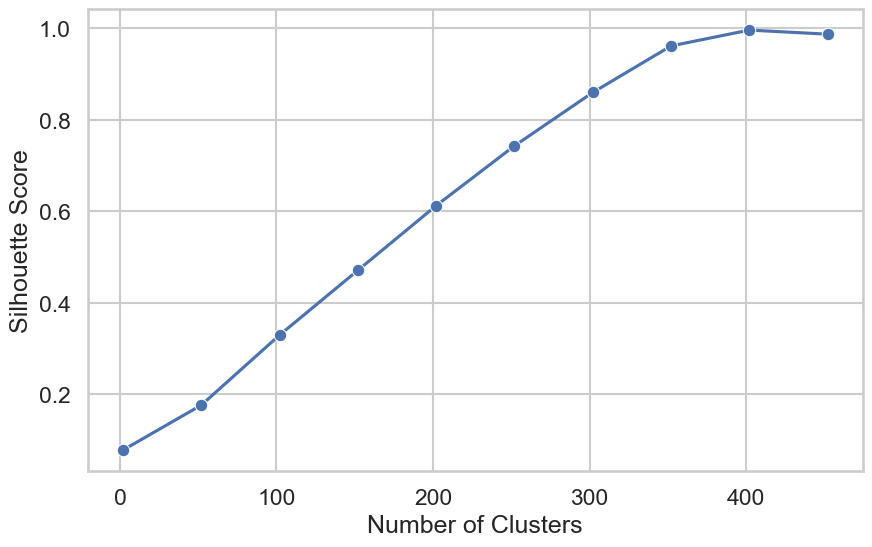

In [50]:
# Convert embeddings to a numpy array
embeddings = np.vstack(data['message_1_embedding'].values)

# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
range_n_clusters = list(range(2, 500, 50))

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=777)
    preds = clusterer.fit_predict(embeddings)
    silhouette_scores.append(silhouette_score(embeddings, preds))


# Create a data frame for the silhouette scores
silhouette_data = pd.DataFrame({
    'Number of Clusters': range_n_clusters,
    'Silhouette Score': silhouette_scores
})

# Set the style and context for the plot
sns.set(style='whitegrid', context='talk')

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Number of Clusters', y='Silhouette Score', marker='o', data=silhouette_data)

# Set the plot labels
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Show the plot
plt.show()

In [53]:
# Based on the plot, choose the optimal number of clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
display(f'Optimal number of clusters: {optimal_clusters}')

# Cluster the text using KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=777)
data['cluster'] = kmeans.fit_predict(embeddings)

# Identify recurring jobs based on clusters
recurring_job_threshold = 2  # Define a threshold for a cluster to be considered recurring

# Group by property_code and cluster, then count the occurrences
cluster_counts_by_property = data.groupby(['property_code', 'cluster']).size().reset_index(name='counts')

# Identify recurring clusters within each property
recurring_clusters_by_property = cluster_counts_by_property[cluster_counts_by_property['counts'] >= recurring_job_threshold]

# Create a dictionary to map clusters to recurring status within each property
recurring_clusters_dict = recurring_clusters_by_property.groupby('property_code')['cluster'].apply(list).to_dict()

# Apply the recurring status to the original dataframe
data['reocurring_job'] = data.apply(
    lambda row: True if row['cluster'] in recurring_clusters_dict.get(row['property_code'], []) else False, axis=1
)

# Display the resulting dataframe
data.head()

# Display the number of recurring jobs
display("Reocurring jobs:")
data['reocurring_job'].value_counts()

'Optimal number of clusters: 402'

,orig_date,property_code,order_number,trade_code,message_1,completed_by_code,completed_by_name,processed_message_1,message_1_embedding,cluster,recurring_job,reocurring_job
0,2023-10-28T00:49:33.678+0000,RRL_YXPV_DLVFAQRY,799528,PLU,leak in bathroom coming from pipe near the roof,WILLIAM_CHANNING,William Channing,leak in bathroom coming from pipe near the roof,"[0.01350963395088911, 0.009661035612225533, -0...",15,False,False
1,2024-04-27T21:22:38.678+0000,MHV_ZBWR_IQYVRNBX,799529,PLU,leak from loft,HENRY_THORNE,Henry Thorne,leak from loft,"[-0.006731612607836723, -0.00742462370544672, ...",301,False,False
2,2024-01-04T01:09:15.678+0000,FCD_DYAH_OSVAJMRV,799530,PLU,URGENT - Leak - underneath the sink has been r...,GRACE_WELLINGTON,Grace Wellington,urgent leak underneath the sink has been repai...,"[0.006772662978619337, -0.0031797843985259533,...",240,False,False
3,2023-11-29T23:53:35.678+0000,BGB_RJUN_DYKUPCLO,799531,PLU,Blocked shower - raise job,JAMES_STIRLING,James Stirling,blocked shower raise job,"[-0.02488315850496292, -0.04133286327123642, -...",40,False,False
4,2024-04-15T21:16:41.678+0000,KBO_RONO_YSEGOIXF,799532,PLU,leak through coving and into kitchen no covid,SAMANTHA_MERCER,Samantha Mercer,leak through coving and into kitchen no covid,"[0.017086341977119446, 0.01357489638030529, 0....",79,False,False


'Reocurring jobs:'

reocurring_job
False    5958
True      191
Name: count, dtype: int64

As we can see above, our approach results with about 3% of reoccuring jobs. Is that reasonable? Maybe. Have I cherry picked my treshold parameter which normally would be based on SME expertise? Yes, I did.

Before moving on we will display records for a single property that have at least one reoccuring job according so you can ponder how good it is - I can definately see a lot of improvments. Plus we will save out final dataset.

In [64]:
# Display records for a property 
data[data["property_code"] == "VKF_JZNK_UTSFBQVF"].sort_values(by=["orig_date", "cluster"])

# Save final dataset
data.to_csv(("%s/SeniorDSTechnicalTest_data_final.csv" % os.getenv("PATH_TO_DATA")).replace("\n", ""), index=False)

,orig_date,property_code,order_number,trade_code,message_1,completed_by_code,completed_by_name,processed_message_1,message_1_embedding,cluster,recurring_job,reocurring_job
580,2023-07-02T02:45:08.678+0000,VKF_JZNK_UTSFBQVF,800108,PLU,P1- leak in bathroom- uncontainable.,CALEB_HAWTHORNE,Caleb Hawthorne,p1 leak in bathroom uncontainable,"[0.02470521256327629, 0.02161877602338791, 0.0...",341,False,False
2698,2023-07-24T22:18:27.678+0000,VKF_JZNK_UTSFBQVF,802226,PLU,(H and S) toilet unable to flush,SAMUEL_LANGFORD,Samuel Langford,h and s toilet unable to flush,"[-0.004470548592507839, 0.028149481862783432, ...",145,False,False
2417,2023-07-26T17:24:42.678+0000,VKF_JZNK_UTSFBQVF,801945,PLU,Leak from bath,WILLIAM_CHANNING,William Channing,leak from bath,"[0.003380679292604327, 0.018100066110491753, 0...",109,False,True
3378,2023-08-06T00:39:20.678+0000,VKF_JZNK_UTSFBQVF,802906,DRA,KITCHEN SINK IS BLOCKED - TNT UNABLE TO CONTAI...,SAMANTHA_MERCER,Samantha Mercer,kitchen sink is blocked tnt unable to contain ...,"[0.005669999867677689, -0.009770377539098263, ...",216,False,False
1959,2023-08-07T21:16:17.678+0000,VKF_JZNK_UTSFBQVF,801487,PLU,Radiator is leaking,CHARLOTTE_MEADOWS,Charlotte Meadows,radiator is leaking,"[-0.0038999132812023163, 0.01709495671093464, ...",334,False,False
84,2023-09-12T23:48:21.678+0000,VKF_JZNK_UTSFBQVF,799612,PLU,Leak from bath,NOAH_HARRINGTON,Noah Harrington,leak from bath,"[0.003380679292604327, 0.018100066110491753, 0...",109,False,True
2922,2023-09-15T21:57:40.678+0000,VKF_JZNK_UTSFBQVF,802450,PLU,"(H and S) only form of bathing, water pouring ...",EDWARD_PEMBROKE,Edward Pembroke,h and s only form of bathing water pouring th...,"[0.0006260811351239681, 0.03913121670484543, 0...",105,False,False
5517,2023-09-28T03:15:44.678+0000,VKF_JZNK_UTSFBQVF,9394935,PLU,dripping mixer tap in the bath also check the ...,LIAM_RADCLIFFE,Liam Radcliffe,dripping mixer tap in the bath also check the ...,"[-0.0028359771240502596, 0.0035339382011443377...",228,False,False
5155,2023-11-01T05:17:58.678+0000,VKF_JZNK_UTSFBQVF,9394573,PLU,P1 - there is a leak coming from pipes from ra...,OLIVER_HARRINGTON,Oliver Harrington,p1 there is a leak coming from pipes from radi...,"[0.019913651049137115, 0.010994560085237026, 0...",123,False,False
868,2023-11-14T00:22:21.678+0000,VKF_JZNK_UTSFBQVF,800396,PLU,H and S LAS not draining away,JAMES_STIRLING,James Stirling,h and s las not draining away,"[-0.009676610119640827, 0.024515939876437187, ...",180,False,False


## 6. Conclusion/Next Steps  <a class="anchor" id="section_6"></a>

a. In terms of the assignment, I hoped I would be able to identify reocurring jobs more quickly so I would actually have time to build a first iteration of a classification model that would predict which jobs would become reoccuring. Moreover I did not really felt I had time to explore different approaches or even run through different hypotheses.

b. The key issue is that currently there is no way to determine which jobs are truly reoccuring so in real-life that would be the key priority to define before proceeding and agree on how that would be measured/tested.

c. There is a lot that we could do here outside of methdolodgical improvements e.g. data enrichment, changes to data collection etc.